In [1]:
import spotchaos.syntheticSignals as sp

import matplotlib
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import matplotlib.animation as animation
from matplotlib.animation import TimedAnimation
from mpl_toolkits import mplot3d
from mpl_toolkits.axes_grid1 import make_axes_locatable
import time
import pickle

import os
from astropy.table import Table
from astropy.timeseries import LombScargle
from scipy.integrate import RK45, DOP853
from scipy.stats import chi2, iqr
from scipy.signal import argrelextrema, savgol_filter, find_peaks_cwt
from scipy.spatial.distance import chebyshev
from scipy.optimize import curve_fit

from pytisean import tiseano, tiseanio

from sklearn.neighbors import KDTree, BallTree
from scipy.spatial import KDTree as scipyKDTree

#%matplotlib inline

In [2]:
# Time series:
# 0. White noise
# 1. stationary GP time series
# 2. Simple periodic
# 3. KB88 R(t)
# 4. Rossler x, y, z
# 5. Transformed rossler u, v, w
# 6. Lorenz x, y, z

# and for each we have 3 baselines: TESS (perfect = 257062 data points), Kepler (perfect = 71422 data points), SPECULOOS (perfect = 44119 data points)
#                   and 4 versions: perfect, gapless+noisy, gappy+noiseless, realistic
# yielding 13*3*4 = 156 time series to analyze altogether. (But only 78 files, because the perfect and noisy versions are in the same file.)

# Need to choose:
# 1. time delay (Fraser & Swinney 1986)
# 2. embedding dimension (Cao 1997)
# and then calculate
# 1. correlation dimension (Kurths & Herzel 1987; investigate pytisean too. Look into Thelier window.)
# 2. Lyapunov spectrum (Wolf et al. 1985)
# 3. Lyapunov dimension (Kaplan-Yorke conjecture; see Eckmann & Ruelle 1985 eq 4.11).

# Expected results:
# 0. White noise should have no good choice of time delay; mutual info as a function of delay time should be flat.
# 1. Not sure!
# 2. Simple periodic and KB88 R(t) results should be similar to KB88 figures 9 and 10.
# 3. same
# 4. Rossler x, y, and z should yield time delay ~ 1/4*rossler_qp and embedding dimension of 3. Rossler z results should be worse than x and y.
# 5. Transformed Rossler u, v, and w should yield time delay ~1/4*transformed_rossler_qp and embedding dimension of 3. Variables should be about equally good.
# 6. Lorenz x, y, and z should yield time delay ~1/4*lorenz_qp and embedding dimension of 3. z dimension will be insensitive to wing symmetry.


In [3]:
folderpaths = ['0_gaussian_noise',
               '1_gaussian_process',
               '2_simple_periodic',
               '3_KB88_r',
               '4_rossler',
               '5_transformed_rossler',
               '6_lorenz']

list_of_tsps = []

In [4]:
class timeSeriesParams(object):
    def __init__(self, filename, filepath, **kwargs):
        self.filename = filename
        self.filepath = filepath
        self.QPmethod = None
        self.QP = None
        self.noisy_QP = None
        self.bestTauIdx = None
        self.noisy_bestTauIdx = None
        self.sat_m = None
        self.noisy_sat_m = None

        self.euclideanCq = None
        self.noisy_euclideanCq = None
        self.euclideanD2 = None
        self.noisy_euclideanD2 = None

        self.tiseanC2 = None
        self.noisy_tiseanC2 = None
        self.tiseanD2 = None
        self.noisy_tiseanD2 = None
        self.tiseanH2 = None
        self.noisy_tiseanH2 = None

        allowed_keys = ["QPmethod","QP","noisy_QP","bestTauIdx","noisy_bestTauIdx","sat_m","noisy_sat_m","euclideanCq","noisy_euclideanCq","euclideanD2","noisy_euclideanD2","tiseanC2","noisy_tiseanC2","tiseanD2","noisy_tiseanD2","tiseanH2","noisy_tiseanH2"]
		
        self.__dict__.update((k,v) for k,v in kwargs.items() if k in allowed_keys)
		
        

In [5]:
def timeSeriesPlot(tsp, savefig=False):
    data = np.genfromtxt(tsp.filepath)

    if "0" in tsp.filename:
        ts = data[:,2]
        noisy_ts = data[:,2]
    else:
        ts = data[:,1]
        noisy_ts = data[:,2]

    fig, axes = plt.subplots(3,1,figsize=(18,12))
    axes[0].plot(data[:,0],ts,marker='.',ms=5,ls='-',color='k',mec='None',lw=0.5,alpha=0.1)
    axes[1].errorbar(data[:,0],noisy_ts,yerr=data[:,3],marker='.',ms=5,ls='-',color='k',mec='None',capsize=0.,elinewidth=0.5,lw=0.5,alpha=0.1)
    axes[2].errorbar(data[:,0],ts-noisy_ts,yerr=data[:,3],marker='.',ms=5,ls='-',color='k',mec='None',capsize=0.,elinewidth=0.5,lw=0.5,alpha=0.1)
    for ax in axes:
        ax.set_xlim(data[:,0][0]-0.5, data[:,0][-1]+0.5)

    axes[0].set_ylabel(r"perfect x(t)",fontsize=14)
    axes[1].set_ylabel(r"noisy x(t)",fontsize=14)
    axes[2].set_ylabel(r"residuals",fontsize=14)
    axes[2].set_xlabel(r"$t$ [days]",fontsize=14)
    if savefig is True:
        plt.savefig("./timeseriesPlots/{0}_timeseriesplot.png".format(tsp.filename.split(".txt")[0]),bbox_inches="tight")
        plt.close()
        
    else:
        plt.show()

    return

In [6]:
def delayPlot(tsp, savefig=False):
    data = np.genfromtxt(tsp.filepath)

    if "0" in tsp.filename:
        ts = data[:,2]
        noisy_ts = data[:,2]
    else:
        ts = data[:,1]
        noisy_ts = data[:,2]
        
    fig, axes = plt.subplots(1,2,sharex=True,sharey=True,figsize=(12,6))
    axes[0].plot(ts[:-tsp.bestTauIdx], ts[tsp.bestTauIdx:],marker='.',ms=5,ls='-',color='k',mec='None',lw=0.5,alpha=0.1)
    axes[1].errorbar(noisy_ts[:-tsp.noisy_bestTauIdx], noisy_ts[tsp.noisy_bestTauIdx:],xerr=data[:,3][:-tsp.noisy_bestTauIdx],yerr=data[:,3][tsp.noisy_bestTauIdx:],marker='.',ms=5,ls='-',color='k',mec='None',capsize=0.,elinewidth=0.5,lw=0.5,alpha=0.01)
    for ax in axes:
        ax.set_xlabel(r"$x(t)$",fontsize=14)
        ax.set_ylabel(r"$x(t+\tau)$",fontsize=14)
        ax.set_aspect("equal")

    if savefig is True:
        plt.savefig("./delayPlots/{0}_delayplot.png".format(tsp.filename.split(".txt")[0]),bbox_inches="tight")
        plt.close()
    else:
        plt.show()
    
    return

In [7]:
def spaceTimePlot(tsp, truncateIdx=None, metric='chebyshev', savefig=False):

    data = np.genfromtxt(tsp.filepath)

    if "0" in tsp.filename:
        ts = data[:,2]
        noisy_ts = data[:,2]
    else:
        ts = data[:,1]
        noisy_ts = data[:,2]

    if tsp.sat_m is None:
        tisean_sat_m = 10
    else:
        tisean_sat_m = tsp.sat_m
    if tsp.noisy_sat_m is None:
        tisean_noisy_sat_m = 10
    else:
        tisean_noisy_sat_m = tsp.noisy_sat_m

    #shorten time series, for debugging/plotting
    if truncateIdx is not None:
        ts = ts[:truncateIdx]
        noisy_ts = noisy_ts[:truncateIdx]
        
    stp = tiseanio("stp",
                    '-d',tsp.bestTauIdx,
                    '-m',tisean_sat_m,
                    '-c',1,
                    '-t',500,
                    silent=True,
                    data=ts)
    stp = stp[0]

    noisy_stp = tiseanio("stp",
                    '-d',tsp.noisy_bestTauIdx,
                    '-m',tisean_noisy_sat_m,
                    '-c',1,
                    '-t',500,
                    silent=True,
                    data=noisy_ts)
    noisy_stp = noisy_stp[0]

    delayMat = sp.delayMatrix(ts, tau=tsp.bestTauIdx, m=tisean_sat_m)
    ball_tree = BallTree(delayMat, leaf_size=10, metric=metric)
    (distances,indices) = ball_tree.query(delayMat, k=np.shape(delayMat)[0],return_distance=True)
    distances = np.ravel(distances[:,1:])
    indices = indices - np.atleast_2d(np.arange(np.shape(delayMat)[0])).T
    indices = np.ravel(indices[:,1:])
    # we don't want to plot each pair of points twice, so limit ourselves to the positive indices
    distances = distances[indices >= 0]
    indices = indices[indices >= 0]

    noisy_delayMat = sp.delayMatrix(noisy_ts, tau=tsp.noisy_bestTauIdx, m=tisean_noisy_sat_m)
    noisy_ball_tree = BallTree(noisy_delayMat, leaf_size=10, metric=metric)
    (noisy_distances, noisy_indices) = noisy_ball_tree.query(noisy_delayMat, k=np.shape(noisy_delayMat)[0],return_distance=True)
    noisy_distances = np.ravel(noisy_distances[:,1:])
    noisy_indices = noisy_indices - np.atleast_2d(np.arange(np.shape(noisy_delayMat)[0])).T
    noisy_indices = np.ravel(noisy_indices[:,1:])
    noisy_distances = noisy_distances[noisy_indices >= 0]
    noisy_indices = noisy_indices[noisy_indices >= 0]
    
    #make spatial separation vs time separation plots, cf Provenzale et al 1992
    fig, axes = plt.subplots(1,2,sharey=True,figsize=(16,6))
    axes[0].plot(indices, distances, 'k.', ms=1,alpha=0.1,label='My code, metric={0}'.format(metric))
    axes[1].plot(noisy_indices, noisy_distances, 'k.',ms=1,alpha=0.1)

    axes[0].plot(stp[:,0], stp[:,1],color='r',marker='.',linestyle='None',ms=1,label='TISEAN, metric=chebyshev')
    axes[1].plot(noisy_stp[:,0], noisy_stp[:,1],color='r',marker='.',linestyle='None',ms=1)

    
    axes[0].axvline(tsp.bestTauIdx,color='b',lw=2,label="best tau = {0}".format(tsp.bestTauIdx))
    axes[0].axvline(5*tsp.bestTauIdx,color='g',lw=2,label="5*best tau")
    
    axes[1].axvline(tsp.noisy_bestTauIdx,color='b',lw=2,label="best tau = {0}".format(tsp.noisy_bestTauIdx))
    axes[1].axvline(5*tsp.noisy_bestTauIdx,color='g',lw=2,label="5*best tau")

    axes[0].legend(loc="lower right",fontsize=12)
    axes[1].legend(loc="lower right",fontsize=12)
    
    for ax in np.ravel(axes):
        ax.set_xlabel(r"separation in time [cadences]",fontsize=12)
        ax.set_ylabel(r"separation in space [units of time series]",fontsize=12)
        ax.set_xlim(0,np.max(indices)/3)
        #ax.set_yscale("log")

    axes[0].set_title("{0}, perfect".format(tsp.filename.split(".txt")[0]))
    axes[1].set_title("noisy")

    if savefig is True: 
        plt.savefig("./spacetimesepPlots/{0}_spacetimesep.png".format(tsp.filename.split(".txt")[0]),bbox_inches="tight")
        plt.close()
    else:
        plt.show()
        
    return

In [8]:
def callAndSaveMyCq(rArr, tsp, mMax=10, timeCall=True, truncateIdx=None):
    data = np.genfromtxt(tsp.filepath)

    if "0" in tsp.filename:
        ts = data[:,2]
        noisy_ts = data[:,2]
    else:
        ts = data[:,1]
        noisy_ts = data[:,2]

    scaleMin = np.min(noisy_ts)
    scaleRange = np.ptp(noisy_ts)

    ts = (ts - scaleMin)/scaleRange
    noisy_ts = (noisy_ts - scaleMin)/scaleRange
    noisy_ts_err = data[:,3]/scaleRange

    if truncateIdx is not None:
        ts = ts[0:truncateIdx]
        noisy_ts = noisy_ts[0:truncateIdx]

    header_tosave = "r"
    for m in range(2,mMax+1):
        header_tosave = header_tosave + " C0m={0}".format(m)
    for m in range(2,mMax+1):
        header_tosave = header_tosave + " C1m={0}".format(m)
    for m in range(2,mMax+1):
        header_tosave = header_tosave + " C2m={0}".format(m)
        
    Cq_tosave = np.zeros((len(rArr),1+3*(mMax-1)))
    Cq_tosave[:,0] = rArr

    noisy_Cq_tosave = np.zeros((len(rArr),1+3*(mMax-1)))
    noisy_Cq_tosave[:,0] = rArr

    #for d2 calculation
    logrArr = np.log10(rArr)
    logrArr_int = (logrArr[0:-1] + logrArr[1:])/2.
    rArr_int = 10**logrArr_int

    d2_header_tosave = "r"
    for m in range(2,mMax+1):
        d2_header_tosave = d2_header_tosave + " D2m={0}".format(m)

    D2_tosave = np.zeros((len(rArr_int),1+(mMax-1)))
    D2_tosave[:,0] = rArr_int

    noisy_D2_tosave = np.zeros((len(rArr_int),1+(mMax-1)))
    noisy_D2_tosave[:,0] = rArr_int
    
    #fig, axes = plt.subplots(1,2,figsize=(16,6))
    for m in range(2, mMax+1):
        print("m is {0}".format(m))
        start_cq = time.time()
    
        C0, C1, C2 = sp.Cq(rArr, ts, tau=tsp.bestTauIdx, m=m, theilerWindow=tsp.bestTauIdx)
        noisy_C0, noisy_C1, noisy_C2 = sp.Cq(rArr, noisy_ts, tau=tsp.noisy_bestTauIdx, m=m, theilerWindow=tsp.noisy_bestTauIdx)
        
        end_cq = time.time()
        if timeCall is True:
            print("Cq call took {0} minutes".format(np.round((end_cq - start_cq)/60, 2)))

        #np.save("./c2arrs/{0}_euclidean_nArr_m={1}.npy".format(tsp.filename.split(".txt")[0],m), nArr)
        #np.save("./c2arrs/{0}_noisy_euclidean_nArr_m={1}.npy".format(tsp.filename.split(".txt")[0],m), noisy_nArr)

        Cq_tosave[:, 1 + (m-2)] = C0
        Cq_tosave[:, 1 + (mMax-1) + (m-2)] = C1
        Cq_tosave[:, 1 + 2*(mMax-1) + (m-2)] = C2

        noisy_Cq_tosave[:, 1 + (m-2)] = noisy_C0
        noisy_Cq_tosave[:, 1 + (mMax-1) + (m-2)] = noisy_C1
        noisy_Cq_tosave[:, 1 + 2*(mMax-1) + (m-2)] = noisy_C2

        D2_tosave[:, 1 + (m-2)] = (np.log10(C2[1:]) - np.log10(C2[0:-1]))/(logrArr[1] - logrArr[0])
        noisy_D2_tosave[:, 1 + (m-2)] = (np.log10(noisy_C2[1:]) - np.log10(noisy_C2[0:-1]))/(logrArr[1] - logrArr[0])
        #axes[0].plot(Cq_tosave[:,0], Cq_tosave[:, 1 + 2*(mMax-1) + (m-2)], marker='.',ls='None')
        #axes[1].plot(D2_tosave[:,0], D2_tosave[:, 1 + (m-2)], marker='.',ls='None')
    #axes[0].set_xscale("log")
    #axes[0].set_yscale("log")
    #axes[1].set_xscale("log")
    #plt.show()

    np.savetxt("./c2arrs/{0}_euclideanCq.txt".format(tsp.filename.split(".txt")[0]), Cq_tosave, fmt="%f", header=header_tosave)
    np.savetxt("./c2arrs/{0}_noisy_euclideanCq.txt".format(tsp.filename.split(".txt")[0]), noisy_Cq_tosave,fmt="%f", header=header_tosave)
    
    np.savetxt("./c2arrs/{0}_euclideanD2.txt".format(tsp.filename.split(".txt")[0]), D2_tosave, fmt="%f", header=d2_header_tosave)
    np.savetxt("./c2arrs/{0}_noisy_euclideanD2.txt".format(tsp.filename.split(".txt")[0]), noisy_D2_tosave,fmt="%f", header=d2_header_tosave)
    
    return

In [9]:
def callAndSaveTiseanC2(rArr, tsp, mMax=10, timeCall=True, truncateIdx=None):
    data = np.genfromtxt(tsp.filepath)

    if "0" in tsp.filename:
        ts = data[:,2]
        noisy_ts = data[:,2]
    else:
        ts = data[:,1]
        noisy_ts = data[:,2]

    scaleMin = np.min(noisy_ts)
    scaleRange = np.ptp(noisy_ts)

    ts = (ts - scaleMin)/scaleRange
    noisy_ts = (noisy_ts - scaleMin)/scaleRange
    noisy_ts_err = data[:,3]/scaleRange

    if truncateIdx is not None:
        ts = ts[0:truncateIdx]
        noisy_ts = noisy_ts[0:truncateIdx]

    start = time.time()
    d2dict = sp.d2_tisean(timeSeries=ts,tau=tsp.bestTauIdx,mMax=mMax,rArr=rArr,thelier=tsp.bestTauIdx)
    firstd2call = time.time()
    noisy_d2dict = sp.d2_tisean(timeSeries=noisy_ts,tau=tsp.noisy_bestTauIdx,mMax=mMax,rArr=rArr,thelier=tsp.noisy_bestTauIdx)
    noisyd2call = time.time()

    if timeCall is True:
        print("first d2 call took {0} seconds".format(np.round(firstd2call-start,2)))
        print("noisy d2 call took {0} seconds".format(np.round(noisyd2call-firstd2call,2)))

    #print(np.shape(d2dict["c2"])) #Always has shape of (len(rArr) * Mmax, 2)
    #print(np.shape(d2dict["d2"])) #Has shape (itDepends, 2)
    #print(np.shape(d2dict["h2"])) #Has shape (itDepends+mMax, 2)

    # TISEAN outputs the results for m=1...mMax all in the same array. Need to sort these out before saving.
    #this is easy for the c2 array, because d2dict["c2"] always has shape (len(rArr) * Mmax, 2)
    c2_header_tosave = "r"
    d2_header_tosave = "r"
    h2_header_tosave = "r"
    for m in range(1,mMax+1):
        c2_header_tosave = c2_header_tosave + " C2m={0}".format(m)
        d2_header_tosave = d2_header_tosave + " D2m={0}".format(m)
        h2_header_tosave = h2_header_tosave + " H2m={0}".format(m)

    c2_tosave = np.zeros((len(rArr), mMax+1))
    c2_tosave[:,0] = d2dict["c2"][0:len(rArr), 0][::-1]

    noisy_c2_tosave = np.zeros((len(rArr), mMax+1))
    noisy_c2_tosave[:,0] = noisy_d2dict["c2"][0:len(rArr), 0][::-1]

    for m in range(1, mMax+1):
        c2_tosave[:,m] = d2dict["c2"][(m-1)*len(rArr) : m*len(rArr), 1][::-1]
        noisy_c2_tosave[:,m] = noisy_d2dict["c2"][(m-1)*len(rArr) : m*len(rArr), 1][::-1]

    np.savetxt("./c2arrs/{0}_tiseanC2.txt".format(tsp.filename.split(".txt")[0]), c2_tosave, fmt="%f", header=c2_header_tosave)
    np.savetxt("./c2arrs/{0}_noisy_tiseanC2.txt".format(tsp.filename.split(".txt")[0]), noisy_c2_tosave, fmt="%f", header=c2_header_tosave)

    #for the d2 and h2 arrays it's more complicated, because these arrays return results for larger and larger rMin as m increases
    diff = (d2dict["d2"][1:,0] - d2dict["d2"][0:-1,0])
    diff_mask = (diff > 0.5)
    noisy_diff = (noisy_d2dict["d2"][1:,0] - noisy_d2dict["d2"][0:-1,0])
    noisy_diff_mask = (noisy_diff > 0.5)

    d2_m_switch_ind = np.arange(len(d2dict["d2"][1:,0]))[diff_mask] + 1
    d2_m_switch_ind = np.concatenate((np.atleast_1d(np.array((0))), d2_m_switch_ind, np.atleast_1d(np.array((len(d2dict["d2"][:,0]))))))
    h2_m_switch_ind = np.concatenate((np.atleast_1d(np.array((0))), d2_m_switch_ind[1:]+np.arange(1, len(d2_m_switch_ind)), np.atleast_1d(np.array((len(d2dict["h2"][:,0]))))))
    
    noisy_d2_m_switch_ind = np.arange(len(noisy_d2dict["d2"][1:,0]))[noisy_diff_mask] + 1
    noisy_d2_m_switch_ind = np.concatenate((np.atleast_1d(np.array((0))), noisy_d2_m_switch_ind,np.atleast_1d(np.array((len(noisy_d2dict["d2"][:,0]))))))
    noisy_h2_m_switch_ind = np.concatenate((np.atleast_1d(np.array((0))), noisy_d2_m_switch_ind[1:]+np.arange(1, len(noisy_d2_m_switch_ind)), np.atleast_1d(np.array((len(noisy_d2dict["h2"][:,0]))))))
    
    
    d2_tosave = np.zeros((d2_m_switch_ind[1], mMax+1))
    noisy_d2_tosave = np.zeros((noisy_d2_m_switch_ind[1], mMax+1))

    d2_tosave[:,0] = d2dict["d2"][d2_m_switch_ind[0]:d2_m_switch_ind[1],0][::-1]
    noisy_d2_tosave[:,0] = noisy_d2dict["d2"][noisy_d2_m_switch_ind[0]:noisy_d2_m_switch_ind[1],0][::-1]

    h2_tosave = np.zeros((h2_m_switch_ind[1], mMax+1))
    noisy_h2_tosave = np.zeros((noisy_h2_m_switch_ind[1], mMax+1))

    h2_tosave[:,0] = d2dict["h2"][h2_m_switch_ind[0]:h2_m_switch_ind[1],0][::-1]
    noisy_h2_tosave[:,0] = noisy_d2dict["h2"][noisy_h2_m_switch_ind[0]:noisy_h2_m_switch_ind[1],0][::-1]

    for m in range(1, mMax+1):
        d2_tosave[:,m] = np.nan
        d2_toskip = len(rArr) - 1 - (d2_m_switch_ind[m] - d2_m_switch_ind[m-1])
        d2_tosave[d2_toskip:,m] = d2dict["d2"][d2_m_switch_ind[m-1]:d2_m_switch_ind[m],1][::-1]

        h2_tosave[:,m] = np.nan
        h2_toskip = len(rArr) - (h2_m_switch_ind[m] - h2_m_switch_ind[m-1])
        h2_tosave[h2_toskip:,m] = d2dict["h2"][h2_m_switch_ind[m-1]:h2_m_switch_ind[m],1][::-1]

        noisy_d2_tosave[:,m] = np.nan
        noisy_d2_toskip = len(rArr) - 1 - (noisy_d2_m_switch_ind[m] - noisy_d2_m_switch_ind[m-1])
        noisy_d2_tosave[noisy_d2_toskip:,m] = noisy_d2dict["d2"][noisy_d2_m_switch_ind[m-1]:noisy_d2_m_switch_ind[m],1][::-1]

        noisy_h2_tosave[:,m] = np.nan
        noisy_h2_toskip = len(rArr) - (noisy_h2_m_switch_ind[m] - noisy_h2_m_switch_ind[m-1])
        noisy_h2_tosave[noisy_h2_toskip:,m] = noisy_d2dict["h2"][noisy_h2_m_switch_ind[m-1]:noisy_h2_m_switch_ind[m],1][::-1]

    np.savetxt("./c2arrs/{0}_tiseanD2.txt".format(tsp.filename.split(".txt")[0]), d2_tosave, fmt="%f", header=d2_header_tosave)
    np.savetxt("./c2arrs/{0}_noisy_tiseanD2.txt".format(tsp.filename.split(".txt")[0]), noisy_d2_tosave, fmt="%f", header=d2_header_tosave)

    np.savetxt("./c2arrs/{0}_tiseanH2.txt".format(tsp.filename.split(".txt")[0]), h2_tosave, fmt="%f", header=h2_header_tosave)
    np.savetxt("./c2arrs/{0}_noisy_tiseanH2.txt".format(tsp.filename.split(".txt")[0]), noisy_h2_tosave, fmt="%f", header=h2_header_tosave)

    return

In [10]:
def loadMyCq(tsp):
    euclideanCq = Table.read("./c2arrs/{0}_euclideanCq.txt".format(tsp.filename.split(".txt")[0]),format="ascii")
    noisy_euclideanCq = Table.read("./c2arrs/{0}_noisy_euclideanCq.txt".format(tsp.filename.split(".txt")[0]),format="ascii")
   
    euclideanD2 = Table.read("./c2arrs/{0}_euclideanD2.txt".format(tsp.filename.split(".txt")[0]),format="ascii")
    noisy_euclideanD2 = Table.read("./c2arrs/{0}_noisy_euclideanD2.txt".format(tsp.filename.split(".txt")[0]),format="ascii")    

    return euclideanCq, noisy_euclideanCq, euclideanD2, noisy_euclideanD2

In [11]:
def loadTiseanC2(tsp):
    C2 = Table.read("./c2arrs/{0}_tiseanC2.txt".format(tsp.filename.split(".txt")[0]),format="ascii")
    noisy_C2 = Table.read("./c2arrs/{0}_noisy_tiseanC2.txt".format(tsp.filename.split(".txt")[0]),format="ascii")

    D2 = Table.read("./c2arrs/{0}_tiseanD2.txt".format(tsp.filename.split(".txt")[0]),format="ascii")
    noisy_D2 = Table.read("./c2arrs/{0}_noisy_tiseanD2.txt".format(tsp.filename.split(".txt")[0]),format="ascii")

    H2 = Table.read("./c2arrs/{0}_tiseanH2.txt".format(tsp.filename.split(".txt")[0]),format="ascii")
    noisy_H2 = Table.read("./c2arrs/{0}_noisy_tiseanH2.txt".format(tsp.filename.split(".txt")[0]),format="ascii")
    
    return C2, noisy_C2, D2, noisy_D2, H2, noisy_H2

In [34]:
# "true" C2 values from Sprott & Rowlands 2000
lorenz_C2_lower = 2.049-0.096
lorenz_C2_upper = 2.049+0.096
lorenz_KY = 2.062
rossler_C2_lower = 1.986-0.078
rossler_C2_upper = 1.986+0.078
rossler_KY = 2.013

def plotC2D2(tsp, mMax=10, savefig=False):
    """
    assumes tsp object now has euclidean and TISEAN C2, D2, etc.
    """
    fig, axes = plt.subplots(2,2,figsize=(12,8))

    for m in range(2,mMax+1):
        axes[0,0].plot(tsp.tiseanC2["r"], tsp.tiseanC2["C2m={0}".format(m)],ms=3,marker='.',c='#FF8585',ls='None')
        axes[0,0].plot(tsp.euclideanCq["r"], tsp.euclideanCq["C2m={0}".format(m)],ms=3,marker='+',c='#9985FF',ls='None')

        axes[0,1].plot(tsp.tiseanD2["r"], tsp.tiseanD2["D2m={0}".format(m)],ms=3,marker='.',c='#FF8585',ls='None')
        axes[0,1].plot(tsp.euclideanD2["r"], tsp.euclideanD2["D2m={0}".format(m)],ms=3,marker='+',c='#9985FF',ls='None')

        axes[1,0].plot(tsp.noisy_tiseanC2["r"], tsp.noisy_tiseanC2["C2m={0}".format(m)],ms=3,marker='.',c='#FF8585',ls='None')
        axes[1,0].plot(tsp.noisy_euclideanCq["r"], tsp.noisy_euclideanCq["C2m={0}".format(m)],ms=3,marker='+',c='#9985FF',ls='None')
        
        axes[1,1].plot(tsp.noisy_tiseanD2["r"], tsp.noisy_tiseanD2["D2m={0}".format(m)],ms=3,marker='.',c='#FF8585',ls='None')
        axes[1,1].plot(tsp.noisy_euclideanD2["r"], tsp.noisy_euclideanD2["D2m={0}".format(m)],ms=3,marker='+',c='#9985FF',ls='None')

    if tsp.sat_m is not None:
        axes[0,0].plot(tsp.tiseanC2["r"], tsp.tiseanC2["C2m={0}".format(tsp.sat_m)], marker='.',ms=7,c='r',ls='None',label="TISEAN")
        axes[0,0].plot(tsp.euclideanCq["r"], tsp.euclideanCq["C2m={0}".format(tsp.sat_m)], marker='+',ms=7, c='b', ls='None',label="Euclidean")

        axes[0,1].plot(tsp.tiseanD2["r"], tsp.tiseanD2["D2m={0}".format(tsp.sat_m)],  marker='.',ms=7,c='r',ls='None')
        axes[0,1].plot(tsp.euclideanD2["r"], tsp.euclideanD2["D2m={0}".format(tsp.sat_m)],  marker='+',ms=7, c='b', ls='None')

    if tsp.noisy_sat_m is not None:
        axes[1,0].plot(tsp.noisy_tiseanC2["r"], tsp.noisy_tiseanC2["C2m={0}".format(tsp.noisy_sat_m)],  marker='.',ms=7,c='r',ls='None')
        axes[1,0].plot(tsp.noisy_euclideanCq["r"], tsp.noisy_euclideanCq["C2m={0}".format(tsp.noisy_sat_m)],  marker='+',ms=7, c='b', ls='None')

        axes[1,1].plot(tsp.noisy_tiseanD2["r"], tsp.noisy_tiseanD2["D2m={0}".format(tsp.noisy_sat_m)],  marker='.',ms=7,c='r',ls='None')
        axes[1,1].plot(tsp.noisy_euclideanD2["r"], tsp.noisy_euclideanD2["D2m={0}".format(tsp.noisy_sat_m)],  marker='+',ms=7, c='b', ls='None')

    for ax in axes[:,0]:
        ax.set_xscale("log")
        ax.set_xlim(7.e-4, 1.5)
        ax.set_yscale("log")
        ax.set_ylim(7.e-7, 1.5)
        ax.set_ylabel("correlation sum")

    for ax in axes[:,1]:
        ax.set_xscale("log")
        ax.set_xlim(7.e-4, 1.5)
        ax.set_ylim(-0.5, 8)
        ax.set_ylabel("correlation dimension")
        if "4" in tsp.filename or "5" in tsp.filename:
            ax.axhline(rossler_KY, color='k',lw=0.5)
            ax.fill_between(np.linspace(7.e-4, 1.5, 3), y1=rossler_C2_lower*np.ones(3),y2=rossler_C2_upper*np.ones(3), color='k',alpha=0.1)
        elif "6" in tsp.filename:
            ax.axhline(lorenz_KY, color='k',lw=0.5)
            ax.fill_between(np.linspace(7.e-4, 1.5, 3), y1=lorenz_C2_lower*np.ones(3),y2=lorenz_C2_upper*np.ones(3), color='k',alpha=0.1)        
    
    axes[0,0].legend(loc="lower right",fontsize=10)

    axes[0,0].set_title("{0}, sat_m = {1}".format(tsp.filename.split(".txt")[0], tsp.sat_m))
    axes[1,0].set_title("noisy sat_m = {0}".format(tsp.noisy_sat_m))

    plt.subplots_adjust(hspace=0.2)

    if savefig is True: 
        plt.savefig("./c2Plots/{0}_C2D2.png".format(tsp.filename.split(".txt")[0]),bbox_inches="tight")
        plt.close()
    else:
        plt.show()
    


In [35]:
list_of_tsp_filenames = []

files = os.scandir(".")
for file in files:
    if ".pickle" in file.name:
        list_of_tsp_filenames.append(file.name)
list_of_tsp_filenames.sort()
print(list_of_tsp_filenames)

['0_gaussianNoise_speculoos_perfect.pickle', '1_gaussianProcess_speculoos_perfect.pickle', '2_simplePeriodic_speculoos_perfect.pickle', '3_KB88r_speculoos_perfect.pickle', '4_rossler_x_speculoos_perfect.pickle', '4_rossler_y_speculoos_perfect.pickle', '4_rossler_z_speculoos_perfect.pickle', '5_transformed_rossler_x_speculoos_perfect.pickle', '5_transformed_rossler_y_speculoos_perfect.pickle', '5_transformed_rossler_z_speculoos_perfect.pickle', '6_lorenz_x_speculoos_perfect.pickle', '6_lorenz_y_speculoos_perfect.pickle', '6_lorenz_z_speculoos_perfect.pickle']


0_gaussianNoise_speculoos_perfect


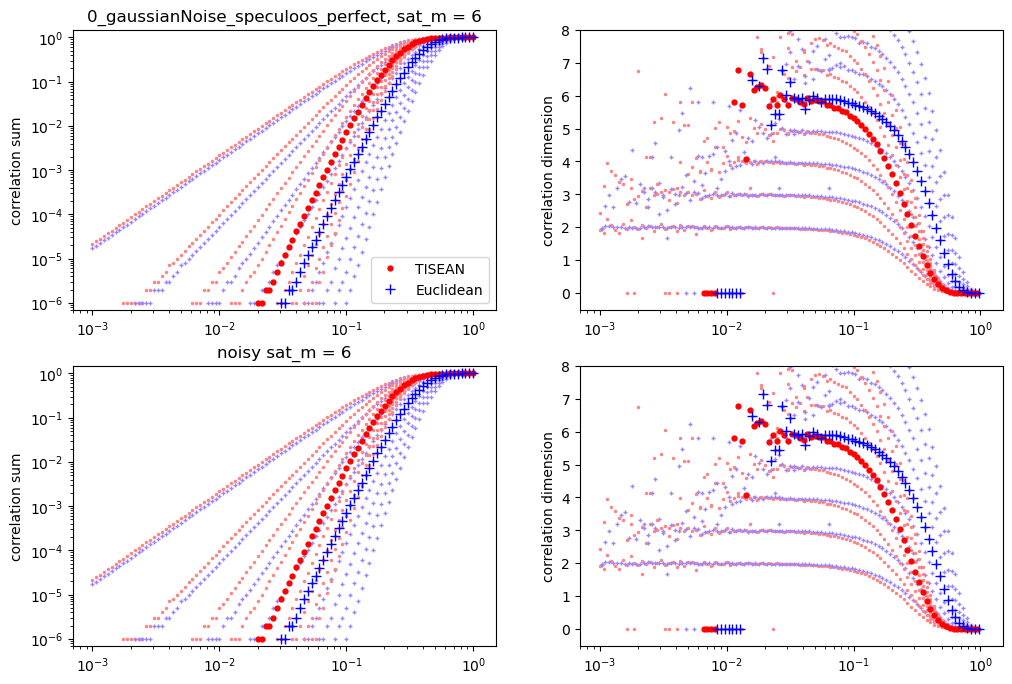

1_gaussianProcess_speculoos_perfect


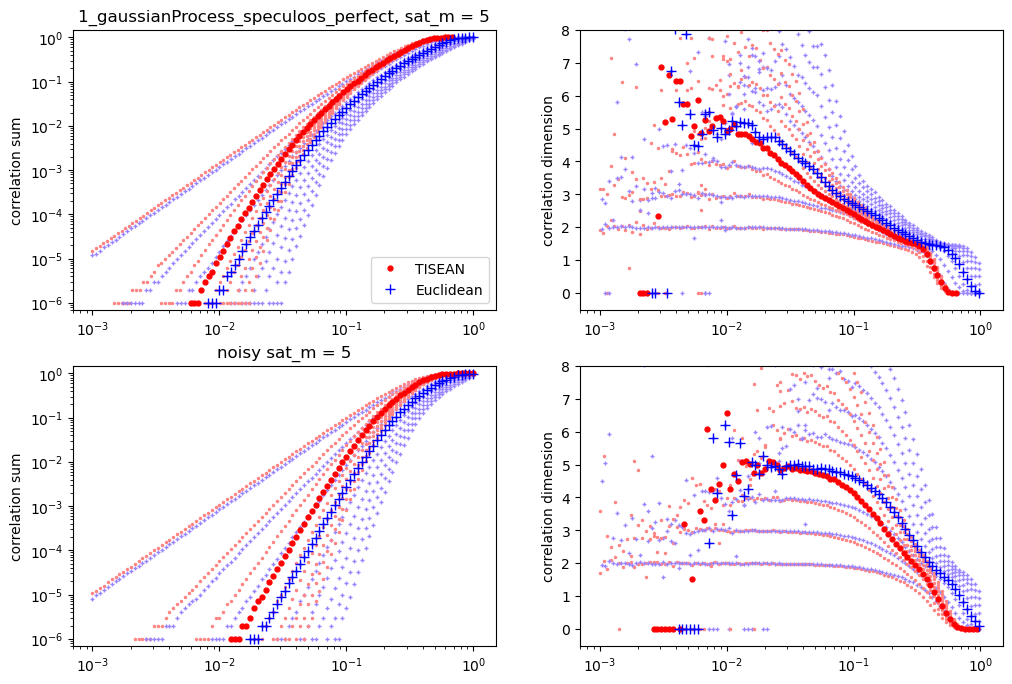

2_simplePeriodic_speculoos_perfect


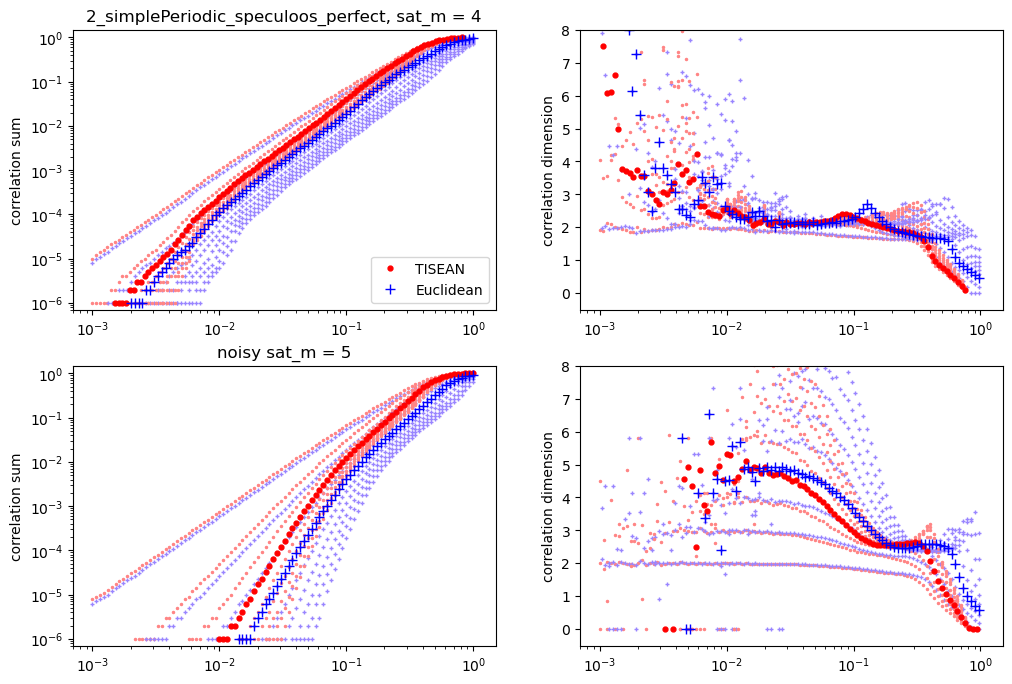

3_KB88r_speculoos_perfect


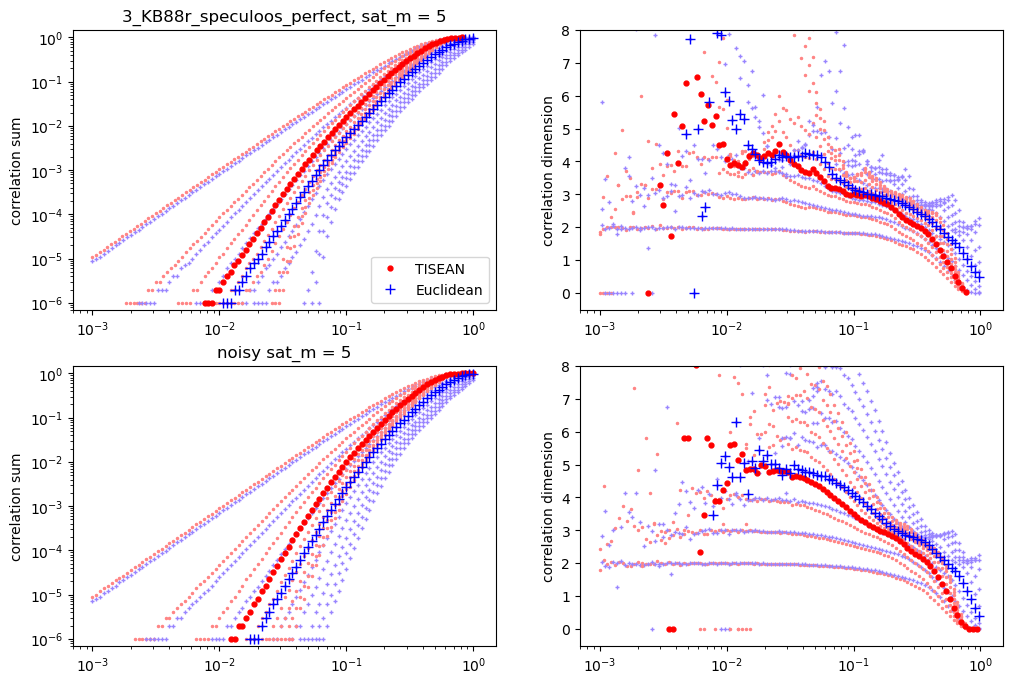

4_rossler_x_speculoos_perfect


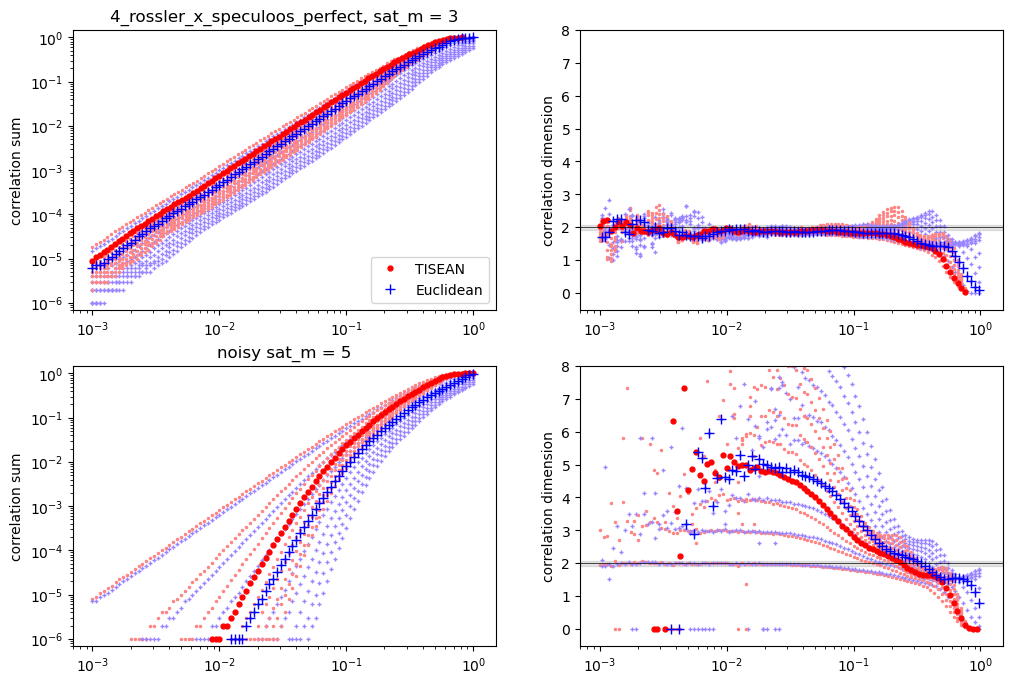

4_rossler_y_speculoos_perfect


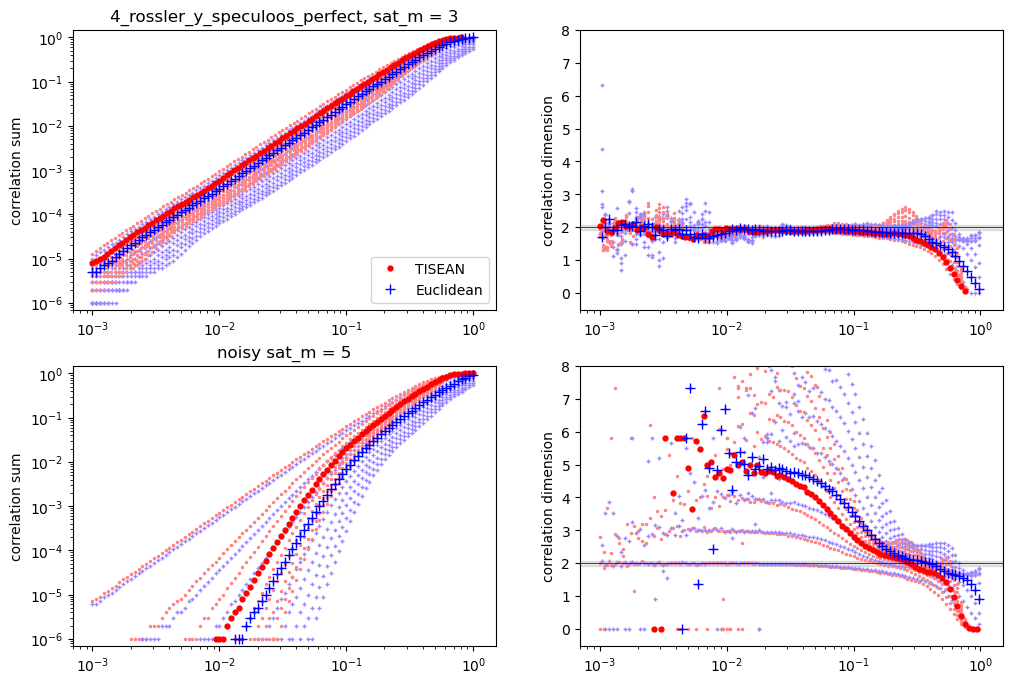

4_rossler_z_speculoos_perfect


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


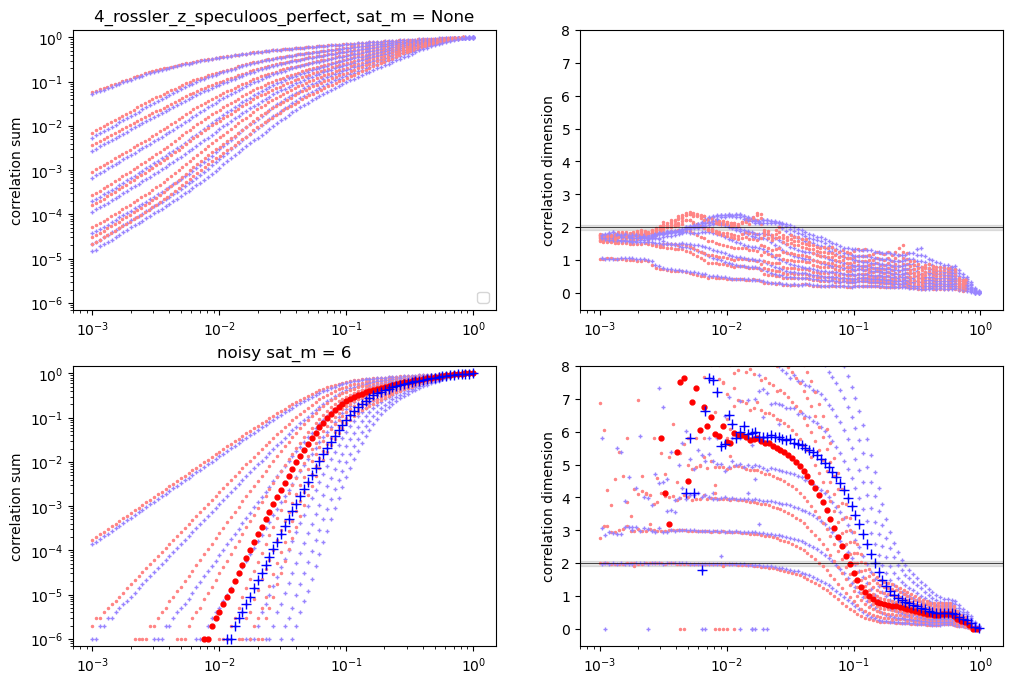

5_transformed_rossler_x_speculoos_perfect


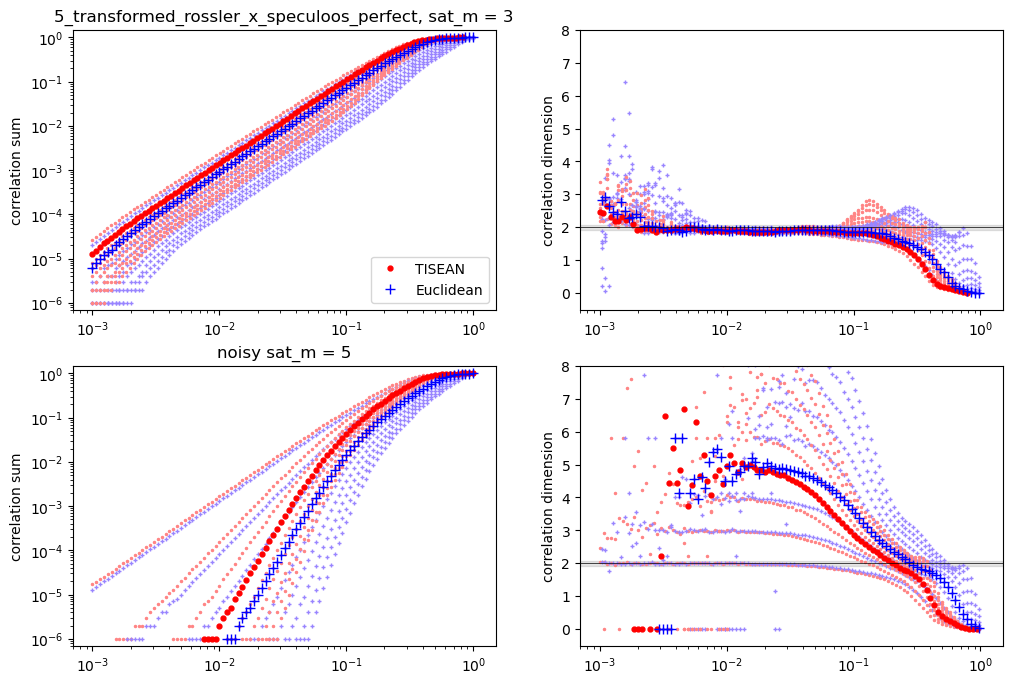

5_transformed_rossler_y_speculoos_perfect


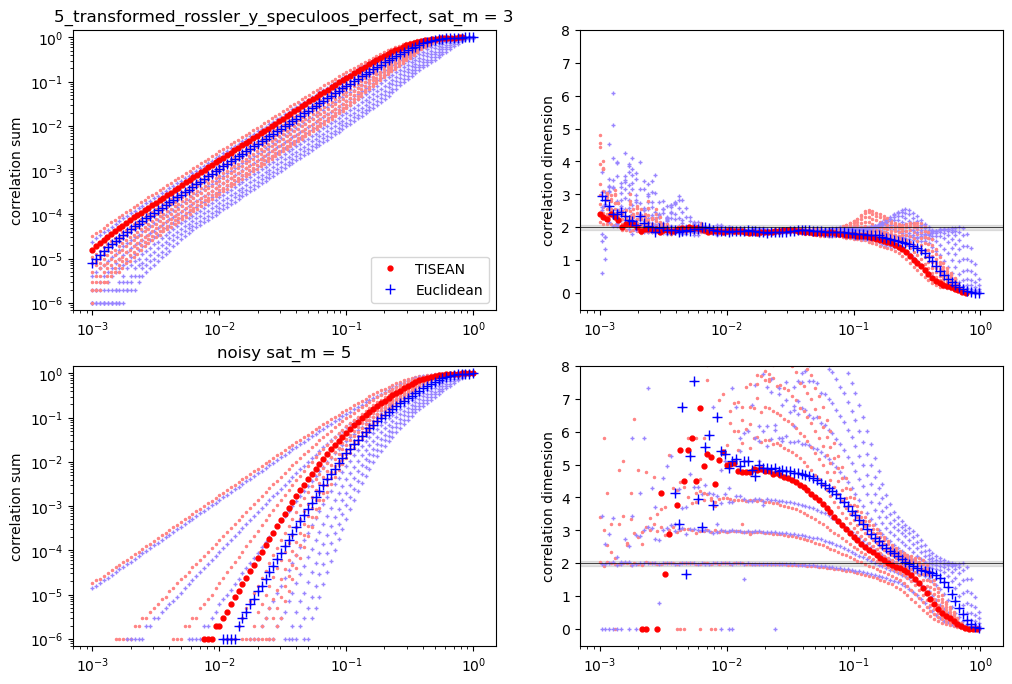

5_transformed_rossler_z_speculoos_perfect


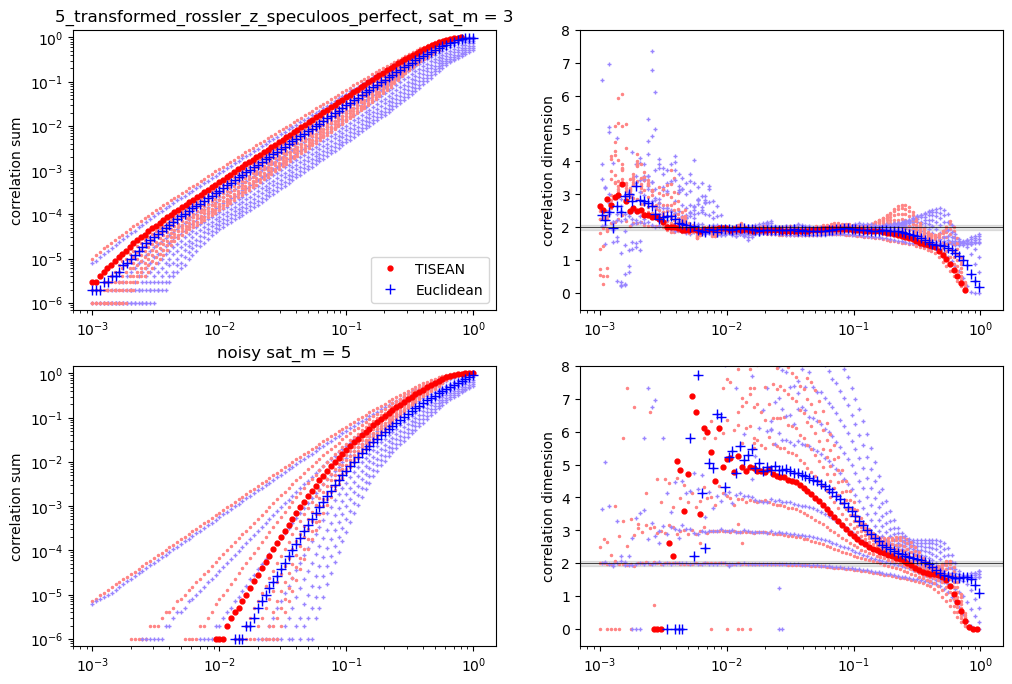

6_lorenz_x_speculoos_perfect


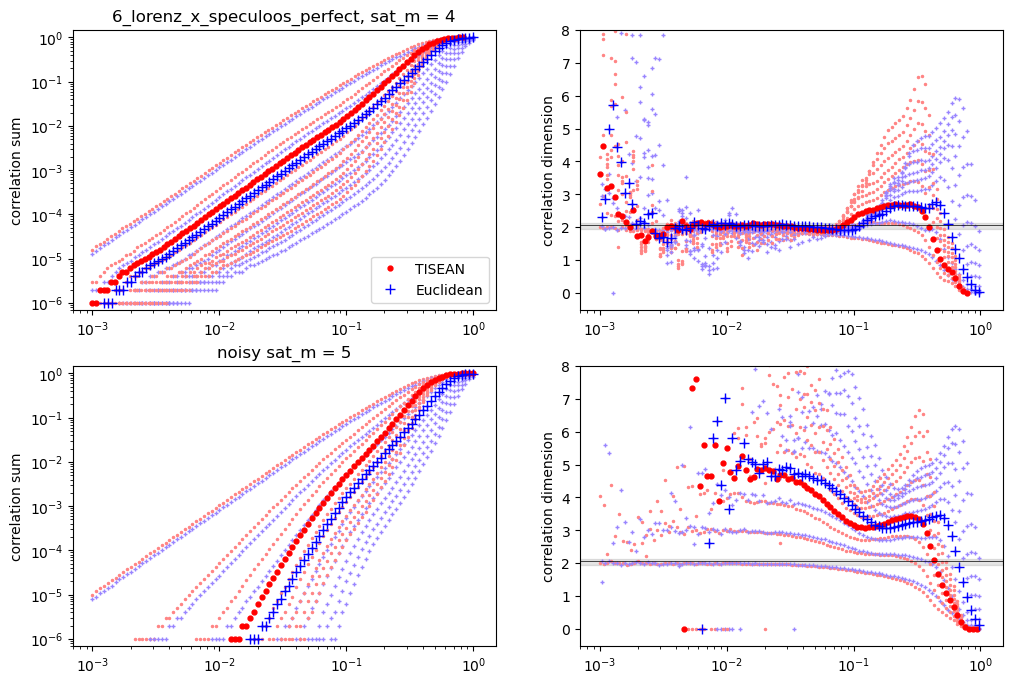

6_lorenz_y_speculoos_perfect


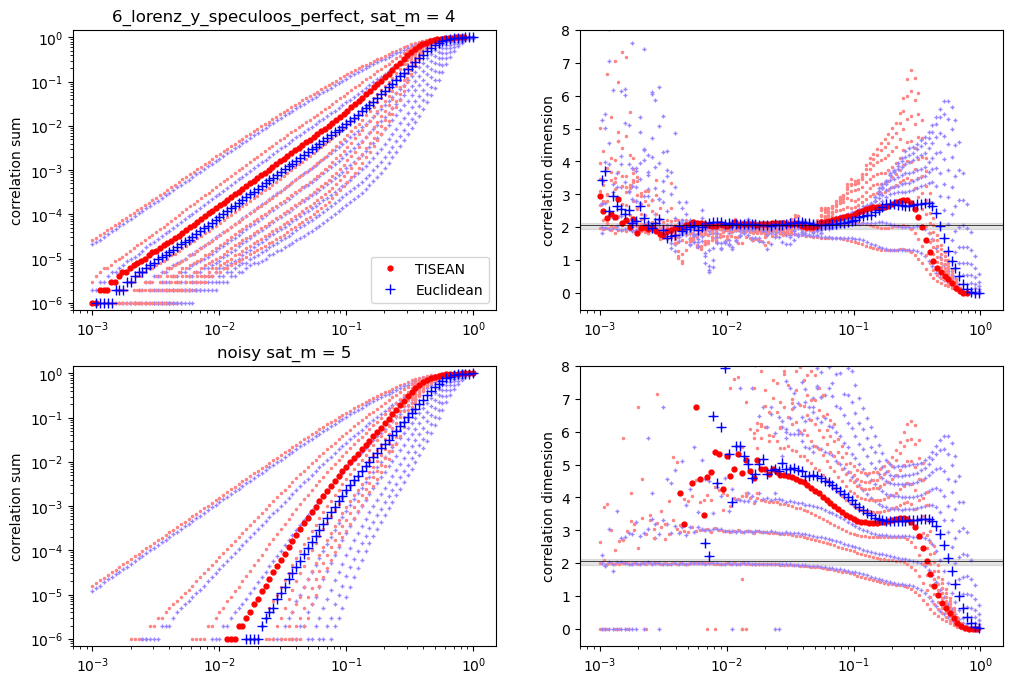

6_lorenz_z_speculoos_perfect


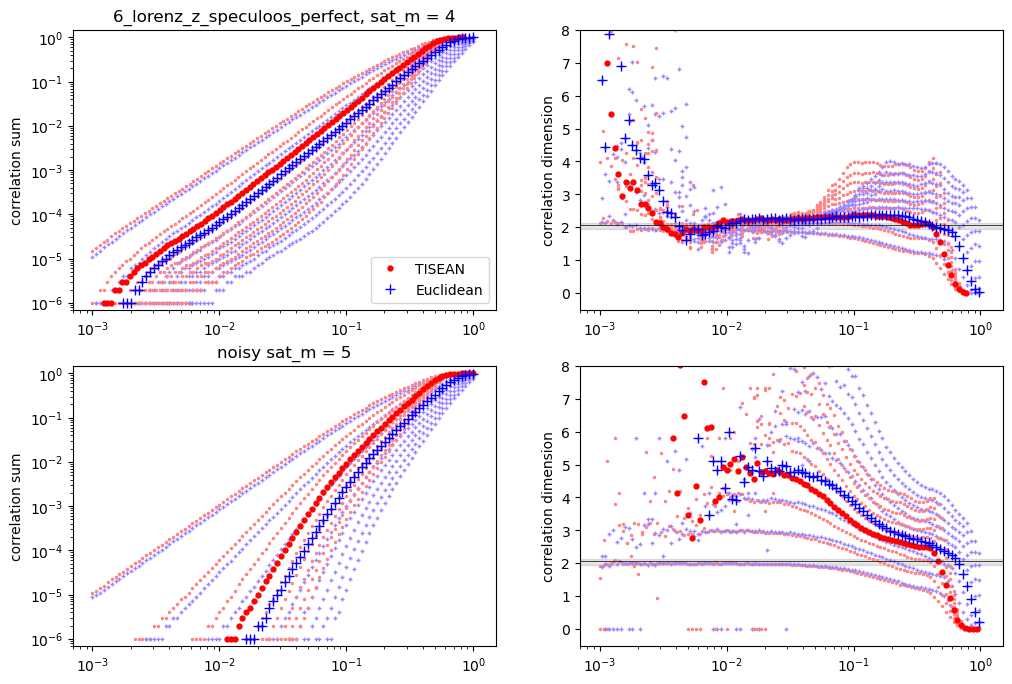

In [36]:
# evenly log-spaced array of r values for c2, d2 calculation
# the data are normalized to fall within the unit cube, so this only needs to range from 0 to 1
min_r = 1.e-3
max_r = 1
logrArr = np.linspace(np.log10(min_r),np.log10(max_r),100)
rArr = 10**logrArr

for tsp_filename in list_of_tsp_filenames:
    with open (tsp_filename, 'rb') as f:
        tsp = pickle.load(f)
        print(tsp.filename.split(".txt")[0])
        data = np.genfromtxt(tsp.filepath)

        if "0" in tsp.filename:
            ts = data[:,2]
            noisy_ts = data[:,2]
        else:
            ts = data[:,1]
            noisy_ts = data[:,2]
        
        #print("perfect tauIdx is {0}, noisy tauIdx is {1}".format(tsp.bestTauIdx, tsp.noisy_bestTauIdx))
        #print("sat_m is {0}, noisy_sat_m is {1}".format(tsp.sat_m, tsp.noisy_sat_m))

        #timeSeriesPlot(tsp,savefig=True)
        #delayPlot(tsp,savefig=True)
        #spaceTimePlot(tsp,metric='euclidean',truncateIdx=5000,savefig=True)

        #print("original time series length is {0}".format(len(ts)))
        
        # scale time series to be between 0 and 1. use the "noisy" scaling for both noisy *and* perfect, 
        #   because we want them to be consistent, but the d2 call relies on all values falling between 0 and 1.
        #scaleMin = np.min(noisy_ts)
        #scaleRange = np.ptp(noisy_ts)

        #ts = (ts - scaleMin)/scaleRange
        #noisy_ts = (noisy_ts - scaleMin)/scaleRange
        #noisy_ts_err = data[:,3]/scaleRange

        #C0, C1, C2, D2 using a Euclidean distance metric
        #callAndSaveMyCq(rArr, tsp, mMax=10, timeCall=True, truncateIdx=None)

        #C2, D2, H2 using TISEAN (chebyshev distance metric)
        #callAndSaveTiseanC2(rArr, tsp, mMax=10, timeCall=True, truncateIdx=None)
        """
        #load C0, C1, C2, D2 using Euclidean distance metric
        Cq, noisy_Cq, D2, noisy_D2 = loadMyCq(tsp)
        tC2, noisy_tC2, tD2, noisy_tD2, tH2, noisy_tH2 = loadTiseanC2(tsp)
    
        tsp.euclideanCq = Cq
        tsp.noisy_euclideanCq = noisy_Cq
        tsp.euclideanD2 = D2
        tsp.noisy_euclideanD2 = noisy_D2

        tsp.tiseanC2 = tC2
        tsp.noisy_tiseanC2 = noisy_tC2
        tsp.tiseanD2 = tD2
        tsp.noisy_tiseanD2 = noisy_tD2
        tsp.tiseanH2 = tH2
        tsp.noisy_tiseanH2 = noisy_tH2
        
        with open('{0}.pickle'.format(tsp.filename.split(".txt")[0]), 'wb') as f:
             # Pickle the 'data' dictionary using the highest protocol available.
            pickle.dump(tsp, f)
        """
        plotC2D2(tsp, mMax=10,savefig=False)
        


In [8]:
for tsp in [list_of_tsps[-1]]:
    
    '''
    
    
    # "true" C2 values from Sprott & Rowlands 2000
    lorenz_C2_lower = 2.049-0.096
    lorenz_C2_upper = 2.049+0.096
    lorenz_KY = 2.062
    rossler_C2_lower = 1.986-0.078
    rossler_C2_upper = 1.986+0.078
    rossler_KY = 2.013
    
    fig, axes = plt.subplots(2,2,figsize=(12,8))
    axes[0,0].scatter(tisean_c2[:,0], tisean_c2[:,1],s=0.1,c='k',label="TISEAN Chebyshev c2, all m")
    axes[0,0].scatter(tisean_c2[(tsp.sat_m-1)*100:tsp.sat_m*100,0], tisean_c2[(tsp.sat_m-1)*100:tsp.sat_m*100,1],s=0.2,c='r',label="TISEAN Chebyshev c2, sat_m")
    axes[0,0].plot(rArr, C2, 'b.',ms=2,ls='None',label="my Euclidean c2")
    axes[0,0].set_yscale('log')
    axes[0,0].set_ylabel("correlation sum")
    axes[0,0].legend(loc="lower right",fontsize=10)

    axes[0,1].scatter(tisean_d2[:,0], tisean_d2[:,1],s=0.1,c='k')
    axes[0,1].scatter(tisean_d2[d2_m_switch_ind[tsp.sat_m-1]:d2_m_switch_ind[tsp.sat_m],0],tisean_d2[d2_m_switch_ind[tsp.sat_m-1]:d2_m_switch_ind[tsp.sat_m],1],s=0.2,c='r')
    axes[0,1].plot(rArr_int, D2, 'b.',ms=2,ls='None')
    axes[0,1].set_ylabel("correlation dimension")

    #axes[0,2].scatter(tisean_h2[:,0], tisean_h2[:,1],s=0.1,c='k')
    #axes[0,2].set_ylabel("correlation entropy")


    axes[1,0].scatter(noisy_tisean_c2[:,0], noisy_tisean_c2[:,1],s=0.1,c='k')
    axes[1,0].scatter(noisy_tisean_c2[(tsp.noisy_sat_m-1)*100:tsp.noisy_sat_m*100,0], noisy_tisean_c2[(tsp.noisy_sat_m-1)*100:tsp.noisy_sat_m*100,1],s=0.2,c='r')
    axes[1,0].plot(rArr, noisy_C2, 'b.',ms=2,ls='None')
    axes[1,0].set_yscale('log')
    axes[1,0].set_ylabel("correlation sum")

    axes[1,1].scatter(noisy_tisean_d2[:,0], noisy_tisean_d2[:,1],s=0.1,c='k')
    axes[1,1].scatter(noisy_tisean_d2[noisy_d2_m_switch_ind[tsp.noisy_sat_m-1]:noisy_d2_m_switch_ind[tsp.noisy_sat_m],0],noisy_tisean_d2[noisy_d2_m_switch_ind[tsp.noisy_sat_m-1]:noisy_d2_m_switch_ind[tsp.noisy_sat_m],1],s=0.2,c='r')
    axes[1,1].plot(rArr_int, noisy_D2, 'b.',ms=2,ls='None')
    axes[1,1].set_ylabel("correlation dimension")

    #axes[1,2].scatter(noisy_tisean_h2[:,0], noisy_tisean_h2[:,1],s=0.1,c='k')
    #axes[1,2].set_ylabel("correlation entropy")

    if "4" in tsp.filename or "5" in tsp.filename:
        for ax in axes[:,1]:
            ax.axhline(rossler_KY, color='k',lw=0.5)
            ax.fill_between(np.linspace(7.e-4, 1.5, 3), y1=rossler_C2_lower*np.ones(3),y2=rossler_C2_upper*np.ones(3), color='k',alpha=0.1)
    elif "6" in tsp.filename:
        for ax in axes[:,1]:
            ax.axhline(lorenz_KY, color='k',lw=0.5)
            ax.fill_between(np.linspace(7.e-4, 1.5, 3), y1=lorenz_C2_lower*np.ones(3),y2=lorenz_C2_upper*np.ones(3), color='k',alpha=0.1)
            
    for ax in np.ravel(axes):
        ax.set_xscale('log')
        ax.set_xlim(7.e-4, 1.5)

    for ax in axes[1]:
        ax.set_xlabel('length scale')

    for ax in axes[:,0]:
        ax.set_ylim(np.min(tisean_c2[:,1]),1.5)

    for ax in axes[:,1]:
        ax.set_ylim(-0.5, 8)

    #for ax in axes[:,2]:
    #    ax.set_ylim(-0.5,6.5)

    axes[0,0].set_title("sat_m = {0}".format(tsp.sat_m))
    axes[1,0].set_title("noisy sat_m = {0}".format(tsp.noisy_sat_m))

    plt.subplots_adjust(hspace=0.2)
    #plt.show()
    plt.savefig("./c2Plots/{0}_short_norm0to1_Cq_comp.png".format(tsp.filename.split(".txt")[0]),bbox_inches="tight")
    plt.close()
    '''

5_transformed_rossler_x_speculoos_perfect.txt
perfect tauIdx is 73, noisy tauIdx is 72
sat_m is 3
noisy_sat_m is 6
original time series length is 44119
8


/var/folders/f8/fqd5scnj31n0br62dg8rnm2w0000gn/T/ipykernel_1134/3898272196.py:164: RuntimeWarning: divide by zero encountered in divide
  C0, C1, C2, nArr = sp.Cq(rArr, ts, tau=tsp.bestTauIdx, m=m, theilerWindow=tsp.bestTauIdx)
/var/folders/f8/fqd5scnj31n0br62dg8rnm2w0000gn/T/ipykernel_1134/3898272196.py:164: RuntimeWarning: divide by zero encountered in log
  C0, C1, C2, nArr = sp.Cq(rArr, ts, tau=tsp.bestTauIdx, m=m, theilerWindow=tsp.bestTauIdx)
/var/folders/f8/fqd5scnj31n0br62dg8rnm2w0000gn/T/ipykernel_1134/3898272196.py:165: RuntimeWarning: divide by zero encountered in divide
  noisy_C0, noisy_C1, noisy_C2, noisy_nArr = sp.Cq(rArr, noisy_ts, tau=tsp.noisy_bestTauIdx, m=m, theilerWindow=tsp.noisy_bestTauIdx)
/var/folders/f8/fqd5scnj31n0br62dg8rnm2w0000gn/T/ipykernel_1134/3898272196.py:165: RuntimeWarning: divide by zero encountered in log
  noisy_C0, noisy_C1, noisy_C2, noisy_nArr = sp.Cq(rArr, noisy_ts, tau=tsp.noisy_bestTauIdx, m=m, theilerWindow=tsp.noisy_bestTauIdx)


Cq call took 23.65 minutes
9


/var/folders/f8/fqd5scnj31n0br62dg8rnm2w0000gn/T/ipykernel_1134/3898272196.py:164: RuntimeWarning: divide by zero encountered in divide
  C0, C1, C2, nArr = sp.Cq(rArr, ts, tau=tsp.bestTauIdx, m=m, theilerWindow=tsp.bestTauIdx)
/var/folders/f8/fqd5scnj31n0br62dg8rnm2w0000gn/T/ipykernel_1134/3898272196.py:164: RuntimeWarning: divide by zero encountered in log
  C0, C1, C2, nArr = sp.Cq(rArr, ts, tau=tsp.bestTauIdx, m=m, theilerWindow=tsp.bestTauIdx)
/var/folders/f8/fqd5scnj31n0br62dg8rnm2w0000gn/T/ipykernel_1134/3898272196.py:165: RuntimeWarning: divide by zero encountered in divide
  noisy_C0, noisy_C1, noisy_C2, noisy_nArr = sp.Cq(rArr, noisy_ts, tau=tsp.noisy_bestTauIdx, m=m, theilerWindow=tsp.noisy_bestTauIdx)
/var/folders/f8/fqd5scnj31n0br62dg8rnm2w0000gn/T/ipykernel_1134/3898272196.py:165: RuntimeWarning: divide by zero encountered in log
  noisy_C0, noisy_C1, noisy_C2, noisy_nArr = sp.Cq(rArr, noisy_ts, tau=tsp.noisy_bestTauIdx, m=m, theilerWindow=tsp.noisy_bestTauIdx)


Cq call took 23.56 minutes
10


/var/folders/f8/fqd5scnj31n0br62dg8rnm2w0000gn/T/ipykernel_1134/3898272196.py:164: RuntimeWarning: divide by zero encountered in divide
  C0, C1, C2, nArr = sp.Cq(rArr, ts, tau=tsp.bestTauIdx, m=m, theilerWindow=tsp.bestTauIdx)
/var/folders/f8/fqd5scnj31n0br62dg8rnm2w0000gn/T/ipykernel_1134/3898272196.py:164: RuntimeWarning: divide by zero encountered in log
  C0, C1, C2, nArr = sp.Cq(rArr, ts, tau=tsp.bestTauIdx, m=m, theilerWindow=tsp.bestTauIdx)
/var/folders/f8/fqd5scnj31n0br62dg8rnm2w0000gn/T/ipykernel_1134/3898272196.py:165: RuntimeWarning: divide by zero encountered in divide
  noisy_C0, noisy_C1, noisy_C2, noisy_nArr = sp.Cq(rArr, noisy_ts, tau=tsp.noisy_bestTauIdx, m=m, theilerWindow=tsp.noisy_bestTauIdx)
/var/folders/f8/fqd5scnj31n0br62dg8rnm2w0000gn/T/ipykernel_1134/3898272196.py:165: RuntimeWarning: divide by zero encountered in log
  noisy_C0, noisy_C1, noisy_C2, noisy_nArr = sp.Cq(rArr, noisy_ts, tau=tsp.noisy_bestTauIdx, m=m, theilerWindow=tsp.noisy_bestTauIdx)


Cq call took 21.23 minutes


In [ ]:
      
    """
    mMax = 8
            
    if tsp.sat_m is None:
        print("no saturation")
        mArr = np.arange(2, mMax+1)
    else:
        if tsp.sat_m + 1 <= mMax:
            mArr = np.array((tsp.sat_m, tsp.sat_m + 1))
        elif tsp.sat_m <= mMax:
            mArr = np.array((tsp.sat_m))
        else:
            mArr = np.arange(2, mMax+1)
    """
    '''
    print(mArr)
            
    for m in mArr:
        print(m)
        if os.path.exists("./{0}_tau={1}_m={2}_C0.npy".format(tsp.filename.split(".txt")[0],tsp.bestTauIdx,m)):
            pass
        else:
            C0_, C1_, C2_, nArr_ = sp.Cq(rArr=rArr, timeSeries=ts, tau = tsp.bestTauIdx, m = m)
            np.save("./{0}_tau={1}_m={2}_C0.npy".format(tsp.filename.split(".txt")[0],tsp.bestTauIdx,m),C0_)
            np.save("./{0}_tau={1}_m={2}_C1.npy".format(tsp.filename.split(".txt")[0],tsp.bestTauIdx,m),C1_)
            np.save("./{0}_tau={1}_m={2}_C2.npy".format(tsp.filename.split(".txt")[0],tsp.bestTauIdx,m),C2_)
            np.save("./{0}_tau={1}_m={2}_nArr.npy".format(tsp.filename.split(".txt")[0],tsp.bestTauIdx,m),nArr_)

            delayMat = sp.delayMatrix(ts, tsp.bestTauIdx, m)
                    
            N = np.shape(nArr_)[0]
            medians = np.percentile(nArr_, 50, axis=0)
                        
            # exclude values of r where the median of n(r) is <= 10./N . Cutoff is a little arbitrary but the idea is that these points don't have enough neighbors.
            enoughNeighborsIdxs = np.arange(len(rArr))[medians > 10./N]
            firstGood = enoughNeighborsIdxs[0]
                   
            exclude values of r where any n(r) are NaN. The time series is not long enough to populate all the neighbors of the points.
            anyNans = [np.any(~np.isfinite(nArr_[:,i])) for i in range(len(rArr))]
            anyNans = np.array(anyNans)
            nansIdxs = np.arange(len(rArr))[anyNans]
            lastGood = nansIdxs[0]
                    
            params_C2, params_unc_C2 = sp.fitLinearRegime(rArr, nArr_, C2_)
                    
            params_dist, params_dist_1sigma = sp.powerLawSlopeDistribution(rArr, nArr_)

            fig, axes = plt.subplots(m,1,figsize=(6, 6*(m-1)))
            axes = np.atleast_1d(axes)
            for j in range(1,m):
                axes[m-1-j].plot(delayMat[:,0],delayMat[:,j],linestyle='-',color='k',lw=0.25,marker="None",zorder=1)
                im = axes[m-1-j].scatter(delayMat[:,0],delayMat[:,j],c=params_dist[:,0],s=10,cmap="magma",linewidths=0,alpha=0.9,zorder=2)
                        
                divider = make_axes_locatable(axes[m-1-j])
                cax = divider.append_axes("right", size="5%", pad=0.05)
                cb = plt.colorbar(im, cax=cax)
                cb.set_label(label=r"Power law slope fit to $n(x_i)$ vs. $r$",fontsize=14)
                        
                axes[m-1-j].set_ylabel(r"$x_i + {0}\tau$".format(j),fontsize=14)
                    
            axes[m-2].set_xlabel(r"$x_i$",fontsize=14)
                    
            im = axes[m-1].scatter(np.arange(0,len(delayMat[:,0])), delayMat[:,0], c=params_dist[:,0],s=10,cmap="magma")
            divider = make_axes_locatable(axes[m-1])
            cax = divider.append_axes("right", size="5%", pad=0.05)
            cb = plt.colorbar(im, cax=cax)
            cb.set_label(label=r"Power law slope fit to $n(x_i)$ vs. $r$",fontsize=14)
            axes[m-1].set_ylabel(r"$x_i$",fontsize=14)
            axes[m-1].set_xlabel("i", fontsize=14)
                    
            n_t = len(delayMat[:,0])//tsp.bestTauIdx
                    
            #for k in range(n_t+1):
            #    axes[m-1].axvline(k*tsp.bestTauIdx, color='k', ls="-",lw=0.5)
                    
            plt.subplots_adjust(hspace=0.2)
            #plt.show()
            plt.savefig("./{0}_m={1}_colormapped_C2.png".format(tsp.filename.split(".txt")[0],m),bbox_inches="tight")
            plt.close()

    """
    if tsp.noisy_sat_m is None:
        print("no saturation")
        noisy_mArr = np.arange(2, mMax+1)
    else:
        if tsp.noisy_sat_m + 1 <= mMax:
            noisy_mArr = np.array((tsp.noisy_sat_m, tsp.noisy_sat_m + 1))
        elif tsp.noisy_sat_m <= mMax:
            tsp.noisy_mArr = np.array((tsp.noisy_sat_m))
        else:
            tsp.noisy_mArr = np.arange(2, mMax+1)
    """
    print(noisy_mArr)
    
    for m in noisy_mArr:
        print(m)
        if os.path.exists("./{0}_tau={1}_m={2}_C0.npy".format(tsp.filename.split(".txt")[0],tsp.noisy_bestTauIdx,m)):
             pass
        else:
            C0_, C1_, C2_, nArr_ = sp.Cq(rArr=rArr, timeSeries=noisy_ts, tau = tsp.noisy_bestTauIdx, m = m)
            np.save("./{0}_tau={1}_m={2}_noisy_C0.npy".format(tsp.filename.split(".txt")[0],tsp.noisy_bestTauIdx,m),C0_)
            np.save("./{0}_tau={1}_m={2}_noisy_C1.npy".format(tsp.filename.split(".txt")[0],tsp.noisy_bestTauIdx,m),C1_)
            np.save("./{0}_tau={1}_m={2}_noisy_C2.npy".format(tsp.filename.split(".txt")[0],tsp.noisy_bestTauIdx,m),C2_)
            np.save("./{0}_tau={1}_m={2}_noisy_nArr.npy".format(tsp.filename.split(".txt")[0],tsp.noisy_bestTauIdx,m),nArr_)

            delayMat = sp.delayMatrix(noisy_ts, tsp.noisy_bestTauIdx, m)
                    
            N = np.shape(nArr_)[0]
            medians = np.percentile(nArr_, 50, axis=0)
                        
            # exclude values of r where the median of n(r) is <= 10./N . Cutoff is a little arbitrary but the idea is that these points don't have enough neighbors.
            enoughNeighborsIdxs = np.arange(len(rArr))[medians > 10./N]
            firstGood = enoughNeighborsIdxs[0]
                    
            # exclude values of r where any n(r) are NaN. The time series is not long enough to populate all the neighbors of the points.
            anyNans = [np.any(~np.isfinite(nArr_[:,i])) for i in range(len(rArr))]
            anyNans = np.array(anyNans)
            nansIdxs = np.arange(len(rArr))[anyNans]
            lastGood = nansIdxs[0]
                    
            params_C2, params_unc_C2 = sp.fitLinearRegime(rArr, nArr_, C2_)
                    
            params_dist, params_dist_1sigma = sp.powerLawSlopeDistribution(rArr, nArr_)

            fig, axes = plt.subplots(m,1,figsize=(6, 6*(m-1)))
            axes = np.atleast_1d(axes)
            for j in range(1,m):
                axes[m-1-j].plot(delayMat[:,0],delayMat[:,j],linestyle='-',color='k',lw=0.25,marker="None",zorder=1)
                im = axes[m-1-j].scatter(delayMat[:,0],delayMat[:,j],c=params_dist[:,0],s=10,cmap="magma",linewidths=0,alpha=0.9,zorder=2)
                        
                divider = make_axes_locatable(axes[m-1-j])
                cax = divider.append_axes("right", size="5%", pad=0.05)
                cb = plt.colorbar(im, cax=cax)
                cb.set_label(label=r"Power law slope fit to $n(x_i)$ vs. $r$",fontsize=14)
                        
                axes[m-1-j].set_ylabel(r"$x_i + {0}\tau$".format(j),fontsize=14)
                    
            axes[m-2].set_xlabel(r"$x_i$",fontsize=14)
                    
            im = axes[m-1].scatter(np.arange(0,len(delayMat[:,0])), delayMat[:,0], c=params_dist[:,0],s=10,cmap="magma")
            divider = make_axes_locatable(axes[m-1])
            cax = divider.append_axes("right", size="5%", pad=0.05)
            cb = plt.colorbar(im, cax=cax)
            cb.set_label(label=r"Power law slope fit to $n(x_i)$ vs. $r$",fontsize=14)
            axes[m-1].set_ylabel(r"$x_i$",fontsize=14)
            axes[m-1].set_xlabel("i", fontsize=14)
                    
            n_t = len(delayMat[:,0])//tsp.noisy_bestTauIdx
                    
            #for k in range(n_t+1):
            #    axes[m-1].axvline(k*tsp.noisy_bestTauIdx, color='k', ls="-",lw=0.5)
                    
            plt.subplots_adjust(hspace=0.2)
            #plt.show()
            plt.savefig("./{0}_m={1}_colormapped_C2_noisy.png".format(tsp.filename.split(".txt")[0],m),bbox_inches="tight")
            plt.close()
    '''
            

# Colormap delay diagrams by recovered dimension

In [26]:
for tsp in list_of_tsps:
    print(tsp.filename)
    data = np.genfromtxt(tsp.filepath)

    if "0" in tsp.filename:
        ts = data[:,2]
        noisy_ts = data[:,2]
    else:
        ts = data[:,1]
        noisy_ts = data[:,2]

    #print("perfect tauIdx is {0}, noisy tauIdx is {1}".format(tsp.bestTauIdx, tsp.noisy_bestTauIdx))
    #print("sat_m is {0}, noisy sat_m is {1}".format(tsp.sat_m, tsp.noisy_sat_m))

    if tsp.sat_m is None:
        tsp.sat_m = 10
    if tsp.noisy_sat_m is None:
        tsp.noisy_sat_m = 10

    #print("original time series length is {0}".format(len(ts)))

            
    # scale ts to be between 0 and 1
    #ts = (ts - np.min(ts))/np.ptp(ts)
    #noisy_ts = (noisy_ts - np.min(noisy_ts))/np.ptp(noisy_ts)

    min_r = 1.e-3
    max_r = 1
    logrArr = np.linspace(np.log10(min_r),np.log10(max_r),100)
    rArr = 10**logrArr
    
    C2 = np.load("./c2arrs/{0}_c2_norm0to1.npy".format(tsp.filename.split(".txt")[0]))
    noisy_C2 = np.load("./c2arrs/{0}_noisy_c2_norm0to1.npy".format(tsp.filename.split(".txt")[0]))

    nArr = np.load("./c2arrs/{0}_nArr_norm0to1.npy".format(tsp.filename.split(".txt")[0]))
    noisy_nArr = np.load("./c2arrs/{0}_noisy_nArr_norm0to1.npy".format(tsp.filename.split(".txt")[0]))

    delayMat = sp.delayMatrix(ts, tsp.bestTauIdx, tsp.sat_m)
    
    N = np.shape(nArr)[0]
    medians = np.percentile(nArr, 50, axis=0)

    # exclude values of r where the median of n(r) is <= 10./N . Cutoff is a little arbitrary but the idea is that these points don't have enough neighbors.
    enoughNeighborsIdxs = np.arange(len(rArr))[medians > 10./N]
    firstGood = enoughNeighborsIdxs[0]
    
    # exclude values of r where any n(r) are NaN. The time series is not long enough to populate all the neighbors of the points.
    anyNans = [np.any(~np.isfinite(nArr[:,i])) for i in range(len(rArr))]
    anyNans = np.array(anyNans)
    nansIdxs = np.arange(len(rArr))[anyNans]
    try:
        lastGood = nansIdxs[0]
    except IndexError:
        lastGood = -1
    
    params_C2, params_unc_C2 = sp.fitLinearRegime(rArr, nArr, C2)
    
    params_dist, params_dist_1sigma = sp.powerLawSlopeDistribution(rArr, nArr)
          
    #print(np.shape(params_dist))
    #print(np.shape(params_dist[:,0]))
    m = tsp.sat_m
    tau = tsp.bestTauIdx
    
    fig, axes = plt.subplots(m,1,figsize=(6, 6*(m-1)))
    axes = np.atleast_1d(axes)
    for j in range(1,m):
        if "0" not in tsp.filename:
            axes[m-1-j].plot(delayMat[:,0],delayMat[:,j],linestyle='-',color='k',lw=0.25,marker="None",zorder=1)
        im = axes[m-1-j].scatter(delayMat[:,0],delayMat[:,j],c=params_dist[:,0],s=2,cmap="magma",linewidths=0,alpha=0.7,zorder=2)
        
        divider = make_axes_locatable(axes[m-1-j])
        cax = divider.append_axes("right", size="5%", pad=0.05)
        cb = plt.colorbar(im, cax=cax)
        cb.set_label(label=r"Power law slope fit to $n(x_i)$ vs. $r$",fontsize=14)
        
        axes[m-1-j].set_ylabel(r"$x_i + {0}\tau$".format(j),fontsize=14)
    
    axes[m-2].set_xlabel(r"$x_i$",fontsize=14)

    if "0" not in tsp.filename:
        axes[m-1].plot(np.arange(0,len(delayMat[:,0])), delayMat[:,0], 'k-',lw=0.25,zorder=1)
    im = axes[m-1].scatter(np.arange(0,len(delayMat[:,0])), delayMat[:,0], c=params_dist[:,0],s=2,cmap="magma",alpha=0.7,zorder=2)
    divider = make_axes_locatable(axes[m-1])
    cax = divider.append_axes("right", size="5%", pad=0.05)
    cb = plt.colorbar(im, cax=cax)
    cb.set_label(label=r"Power law slope fit to $n(x_i)$ vs. $r$",fontsize=14)
    axes[m-1].set_ylabel(r"$x_i$",fontsize=14)
    axes[m-1].set_xlabel("i", fontsize=14)
    
    n_t = len(delayMat[:,0])//tau
    
    #for k in range(n_t+1):
    #    axes[m-1].axvline(k*tau, color='k', ls="-",lw=0.5)

    for ax in axes[0:-1]:
        ax.set_aspect("equal")
        
    plt.subplots_adjust(hspace=0.2)
    #plt.show()
    plt.savefig("./delayPlots/{0}_delayplot_C2colormap.png".format(tsp.filename.split(".txt")[0]),bbox_inches="tight")
    plt.close()
    

3_KB88r_speculoos_perfect.txt


/var/folders/f8/fqd5scnj31n0br62dg8rnm2w0000gn/T/ipykernel_37088/161106567.py:56: RuntimeWarning: invalid value encountered in divide
  params_C2, params_unc_C2 = sp.fitLinearRegime(rArr, nArr, C2)
/var/folders/f8/fqd5scnj31n0br62dg8rnm2w0000gn/T/ipykernel_37088/161106567.py:56: RuntimeWarning: divide by zero encountered in log10
  params_C2, params_unc_C2 = sp.fitLinearRegime(rArr, nArr, C2)
/var/folders/f8/fqd5scnj31n0br62dg8rnm2w0000gn/T/ipykernel_37088/161106567.py:58: RuntimeWarning: divide by zero encountered in log10
  params_dist, params_dist_1sigma = sp.powerLawSlopeDistribution(rArr, nArr)


4_rossler_y_speculoos_perfect.txt
1_gaussianProcess_speculoos_perfect.txt
5_transformed_rossler_z_speculoos_perfect.txt
0_gaussianNoise_speculoos_perfect.txt
4_rossler_x_speculoos_perfect.txt
6_lorenz_z_speculoos_perfect.txt
5_transformed_rossler_y_speculoos_perfect.txt
6_lorenz_x_speculoos_perfect.txt
2_simplePeriodic_speculoos_perfect.txt
4_rossler_z_speculoos_perfect.txt
6_lorenz_y_speculoos_perfect.txt
5_transformed_rossler_x_speculoos_perfect.txt
